In [4]:
using DifferentialEquations, Plots, Test, BenchmarkTools
using Perla1

In [5]:
function solve_transition_dynamics(Q, f0)
    df(f,p,a) = Q(a)' * f
    prob = ODEProblem(df,f0,(0.0,1.0))
    sol = solve(prob)
end

solve_transition_dynamics (generic function with 1 method)

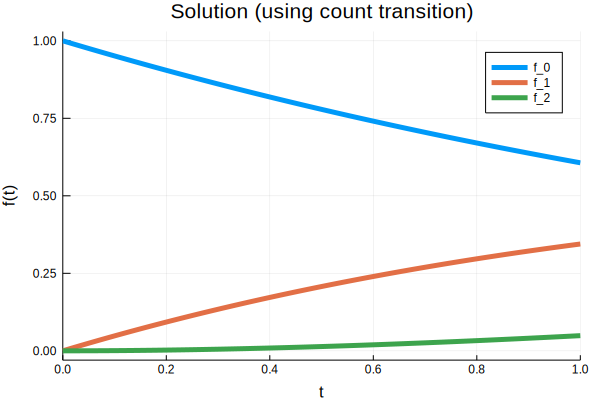

In [8]:
# simple duopoly
N = 2
μ = 0.0
θ = 0.5
θ_d = 0.00

# define generator
Q_a = get_Q(N, μ, θ, θ_d)
Q(a) = Q_a(0) # fix Q to be time invariant

# solve the corresponding ODE
f_0 = [1.0; 0.0; 0.0]
sol_count = solve_transition_dynamics(Q, f_0)

# convert to the counting solution
f_0_count(a) = sol_count(a)[1]
f_1_count(a) = sol_count(a)[2]
f_2_count(a) = sol_count(a)[3]

# plot
plot(sol_count,linewidth=5,
    title="Solution (using count transition)",
    xaxis="t",yaxis="f(t)",label=["f_0" "f_1" "f_2"])

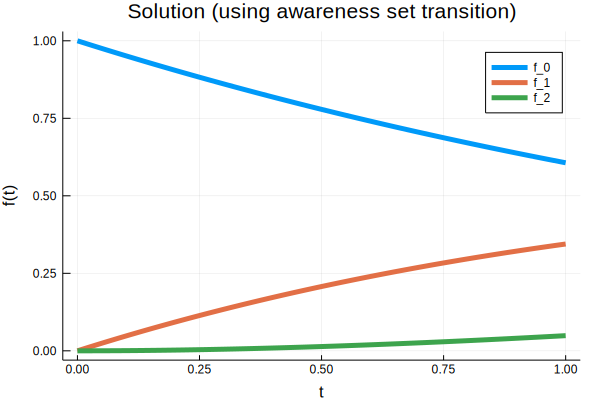

In [9]:
# simple duopoly, using awareness set
# define generator
f_hat0(a) = (θ_d + θ) / (θ_d + θ*exp((θ_d + θ)*a)) # (A.4) in appendix
f_hat_0 = [1; 0.0; 0.0; 0.0]
Q_hat(a) = [-(θ + θ_d*(1-f_hat0(a)[1])) (θ + θ_d*(1-f_hat0(a)[1]))/N (θ + θ_d*(1-f_hat0(a)[1]))/N 0.0; 
            0.0 -θ/2 0.0 θ/2;
            0.0 0.0 -θ/2 θ/2;
            0.0 0.0 0.0 0.0]

# solve the corresponding ODE
sol_awareness = solve_transition_dynamics(Q_hat, f_hat_0)

# convert to the counting solution
f_0_awareness(a) = sol_awareness(a)[1] # no product
f_1_awareness(a) = sol_awareness(a)[2] + sol_awareness(a)[3] # product 1 or product 2
f_2_awareness(a) = sol_awareness(a)[4] # two products

# plot
plot(0:0.01:1, [f_0_awareness, f_1_awareness, f_2_awareness],linewidth=5,
    title="Solution (using awareness set transition)",
     xaxis="t",yaxis="f(t)",label=["f_0" "f_1" "f_2"])

In [10]:
@test f_0_count.(0:0.1:1) ≈ f_0_awareness.(0:0.1:1) atol=1e-6
@test f_1_count.(0:0.1:1) ≈ f_1_awareness.(0:0.1:1) atol=1e-6
@test f_2_count.(0:0.1:1) ≈ f_2_awareness.(0:0.1:1) atol=1e-6

Test Passed